# Brain Tumor Detection Using a Convolutional Neural Network

## Import Necessary Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

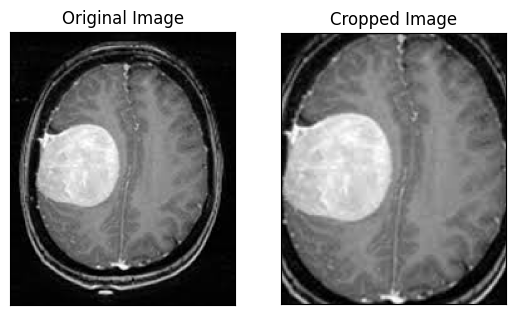

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4128
X shape is: (4128, 240, 240, 3)
y shape is: (4128, 1)


### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

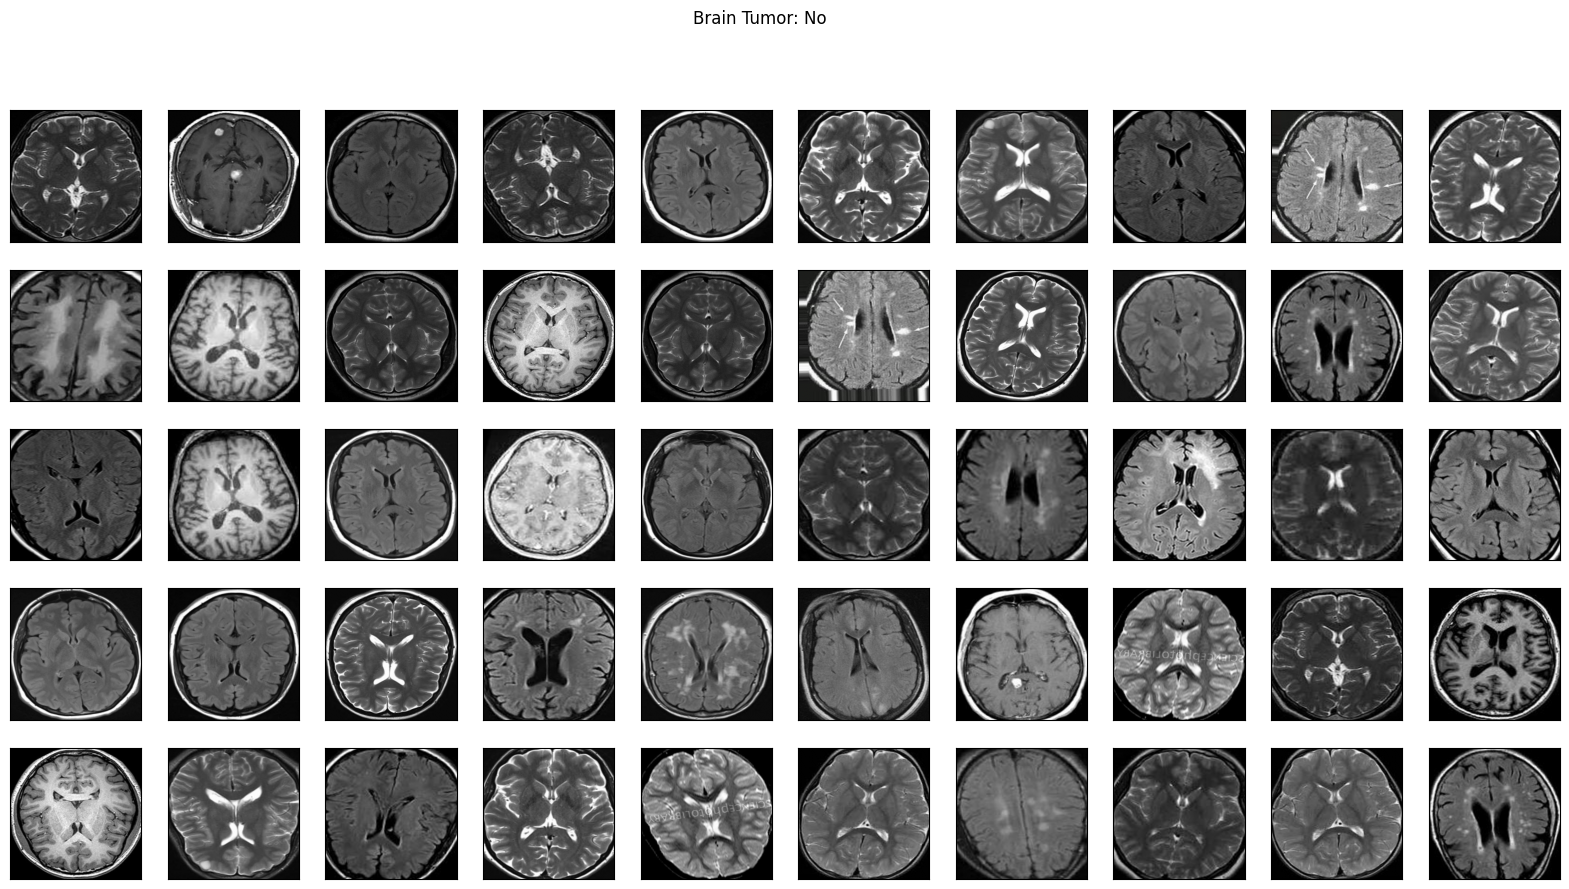

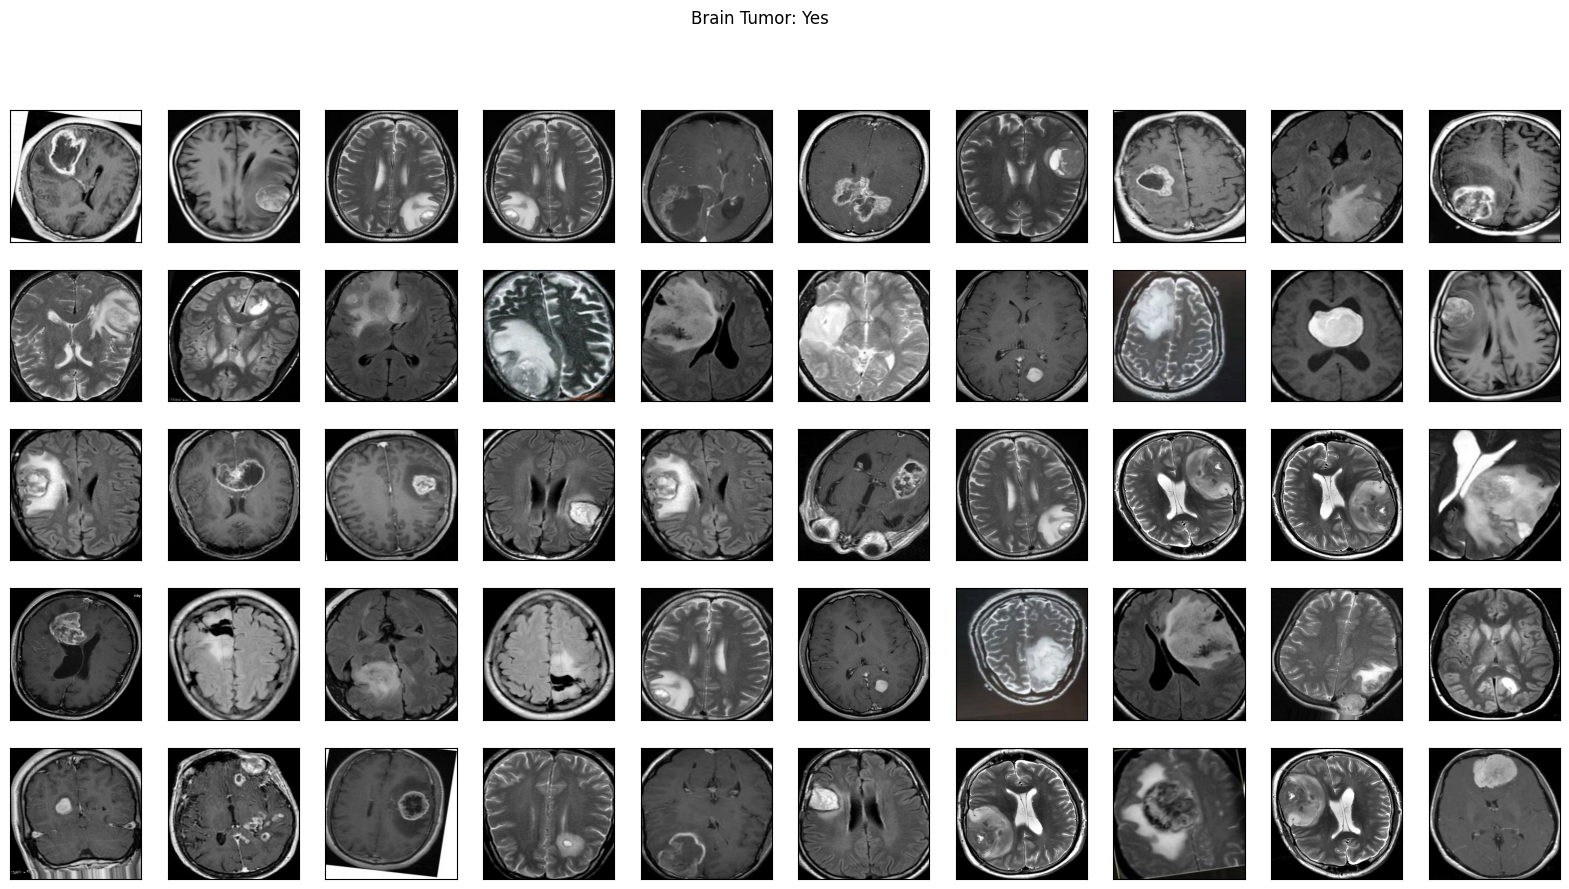

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2889
number of development examples = 620
number of test examples = 619
X_train shape: (2889, 240, 240, 3)
Y_train shape: (2889, 1)
X_val (dev) shape: (620, 240, 240, 3)
Y_val (dev) shape: (620, 1)
X_test shape: (619, 240, 240, 3)
Y_test shape: (619, 1)


Some helper functions:

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [14]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
91/91 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.6608

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.72.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.72.model\assets


91/91 [==============================] - 102s 1s/step - loss: 0.7658 - accuracy: 0.6608 - val_loss: 0.6126 - val_accuracy: 0.7177
Epoch 2/10
91/91 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8024

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.82.model\assets


91/91 [==============================] - 98s 1s/step - loss: 0.4287 - accuracy: 0.8024 - val_loss: 0.4959 - val_accuracy: 0.8161
Epoch 3/10
91/91 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8332

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.66.model\assets


91/91 [==============================] - 96s 1s/step - loss: 0.3861 - accuracy: 0.8332 - val_loss: 0.5783 - val_accuracy: 0.6629
Epoch 4/10
91/91 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8612

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.78.model\assets


91/91 [==============================] - 96s 1s/step - loss: 0.3308 - accuracy: 0.8612 - val_loss: 0.4878 - val_accuracy: 0.7806
Epoch 5/10
91/91 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.8567

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.67.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.67.model\assets


91/91 [==============================] - 92s 1s/step - loss: 0.3186 - accuracy: 0.8567 - val_loss: 0.8965 - val_accuracy: 0.6661
Epoch 6/10
91/91 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.8650

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.66.model\assets


91/91 [==============================] - 90s 995ms/step - loss: 0.3172 - accuracy: 0.8650 - val_loss: 0.9605 - val_accuracy: 0.6597
Epoch 7/10
91/91 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.8989

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.88.model\assets


91/91 [==============================] - 90s 993ms/step - loss: 0.2445 - accuracy: 0.8989 - val_loss: 0.3449 - val_accuracy: 0.8758
Epoch 8/10
91/91 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.8972

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.91.model\assets


91/91 [==============================] - 90s 993ms/step - loss: 0.2434 - accuracy: 0.8972 - val_loss: 0.3040 - val_accuracy: 0.9097
Epoch 9/10
91/91 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9148

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


91/91 [==============================] - 91s 1s/step - loss: 0.2170 - accuracy: 0.9148 - val_loss: 0.3525 - val_accuracy: 0.8774
Epoch 10/10
91/91 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9159

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.67.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.67.model\assets


91/91 [==============================] - 94s 1s/step - loss: 0.2044 - accuracy: 0.9159 - val_loss: 0.8252 - val_accuracy: 0.6710
Elapsed time: 0:15:44.4


Let's train for a few more epochs:

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
91/91 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9211

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.71.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.71.model\assets


91/91 [==============================] - 113s 1s/step - loss: 0.2015 - accuracy: 0.9211 - val_loss: 0.6904 - val_accuracy: 0.7065
Epoch 2/3
91/91 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9335

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.65.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.65.model\assets


91/91 [==============================] - 92s 1s/step - loss: 0.1712 - accuracy: 0.9335 - val_loss: 0.8879 - val_accuracy: 0.6548
Epoch 3/3
91/91 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9335

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.91.model\assets


91/91 [==============================] - 91s 1s/step - loss: 0.1797 - accuracy: 0.9335 - val_loss: 0.2877 - val_accuracy: 0.9113
Elapsed time: 0:5:3.3


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
91/91 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9429

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.91.model\assets


91/91 [==============================] - 111s 1s/step - loss: 0.1497 - accuracy: 0.9429 - val_loss: 0.2802 - val_accuracy: 0.9145
Epoch 2/3
91/91 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9401

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


91/91 [==============================] - 101s 1s/step - loss: 0.1578 - accuracy: 0.9401 - val_loss: 0.3880 - val_accuracy: 0.8565
Epoch 3/3
91/91 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9408

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.93.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.93.model\assets


91/91 [==============================] - 95s 1s/step - loss: 0.1569 - accuracy: 0.9408 - val_loss: 0.2573 - val_accuracy: 0.9258
Elapsed time: 0:5:15.3


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
91/91 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9612

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.92.model\assets


91/91 [==============================] - 108s 1s/step - loss: 0.1149 - accuracy: 0.9612 - val_loss: 0.2910 - val_accuracy: 0.9177
Epoch 2/3
91/91 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9654

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.81.model\assets


91/91 [==============================] - 93s 1s/step - loss: 0.1087 - accuracy: 0.9654 - val_loss: 0.5075 - val_accuracy: 0.8145
Epoch 3/3
91/91 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9488

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.92.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.92.model\assets


91/91 [==============================] - 92s 1s/step - loss: 0.1410 - accuracy: 0.9488 - val_loss: 0.2907 - val_accuracy: 0.9194
Elapsed time: 0:4:59.8


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
91/91 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9657

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.91.model\assets


91/91 [==============================] - 108s 1s/step - loss: 0.1029 - accuracy: 0.9657 - val_loss: 0.2544 - val_accuracy: 0.9145
Epoch 2/5
91/91 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9481

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.90.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.90.model\assets


91/91 [==============================] - 94s 1s/step - loss: 0.1326 - accuracy: 0.9481 - val_loss: 0.3425 - val_accuracy: 0.9048
Epoch 3/5
91/91 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9682

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.86.model\assets


91/91 [==============================] - 91s 1s/step - loss: 0.0948 - accuracy: 0.9682 - val_loss: 0.5312 - val_accuracy: 0.8581
Epoch 4/5
91/91 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9747

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.91.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.91.model\assets


91/91 [==============================] - 91s 1s/step - loss: 0.0853 - accuracy: 0.9747 - val_loss: 0.2758 - val_accuracy: 0.9145
Epoch 5/5
91/91 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9806

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.95.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.95.model\assets


91/91 [==============================] - 93s 1s/step - loss: 0.0688 - accuracy: 0.9806 - val_loss: 0.2209 - val_accuracy: 0.9452
Elapsed time: 0:8:1.1


In [26]:
model.save('saved_model/project_model')
history = model.history.history

INFO:tensorflow:Assets written to: saved_model/project_model\assets


INFO:tensorflow:Assets written to: saved_model/project_model\assets


In [27]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

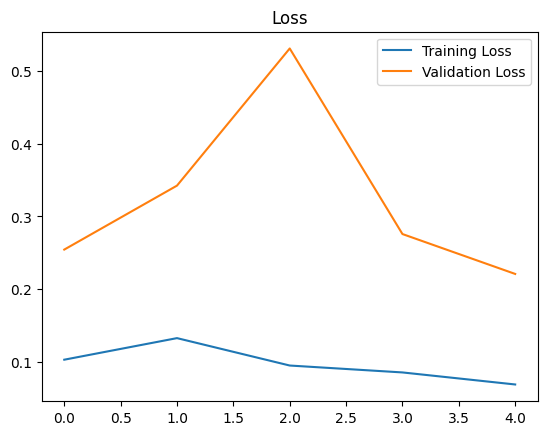

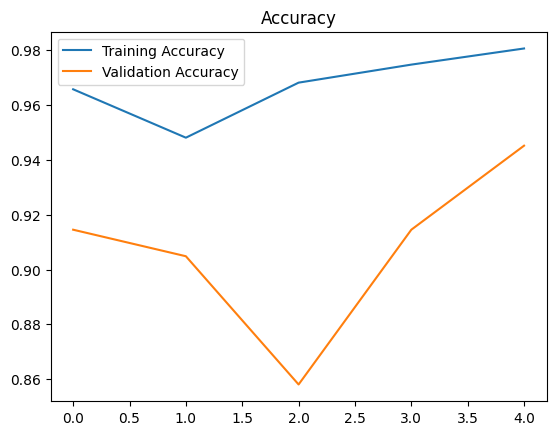

In [29]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [30]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [31]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [32]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

20/20 [==============================] - 4s 192ms/step - loss: 0.2149 - accuracy: 0.9435


### Accuracy of the best model on the testing data:

In [33]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.2149360477924347
Test Accuracy = 0.9434571862220764


### F1 score for the best model on the testing data:

In [34]:
y_test_prob = best_model.predict(X_test)

20/20 [==============================] - 7s 194ms/step


In [35]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9465648854961832


Let's also find the f1 score on the validation data:

In [36]:
y_val_prob = best_model.predict(X_val)

20/20 [==============================] - 4s 189ms/step


In [37]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9367816091954023


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [38]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [39]:
# the whole data
data_percentage(y)

Number of examples: 4128
Percentage of positive examples: 52.56782945736434%, number of pos examples: 2170
Percentage of negative examples: 47.43217054263566%, number of neg examples: 1958


In [40]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 2889
Percentage of positive examples: 51.33264105226722%, number of pos examples: 1483
Percentage of negative examples: 48.66735894773278%, number of neg examples: 1406
Validation Data:
Number of examples: 620
Percentage of positive examples: 56.45161290322581%, number of pos examples: 350
Percentage of negative examples: 43.54838709677419%, number of neg examples: 270
Testing Data:
Number of examples: 619
Percentage of positive examples: 54.44264943457189%, number of pos examples: 337
Percentage of negative examples: 45.55735056542811%, number of neg examples: 282
